**Обучение генеративной модели для создания изображений**

# Подготовка датасета

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import v2, CenterCrop
from PIL import Image
from torchvision import datasets, transforms, utils
import torch.nn.functional as F
from torchvision import models
import matplotlib.pyplot as plt
import torchvision.utils
import imageio

In [2]:
image_size = 50
batch_size = 32
epoch = 50
learning_rate = 0.001

In [ ]:
##########################################
def gaus_noise(image, mean=0.0, std=0.1):
    noise = torch.randn_like(image) * std + mean
    noisy_image = image + noise
    noisy_image = torch.clamp(noisy_image, -1.0, 1.0)
    return noisy_image

In [3]:
class ImageDataset(Dataset):
    def __init__(self, folder_path, transform=None, noise_function=None):
        self.folder_path = folder_path
        self.image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.JPEG'))]
        self.transform = transform
        self.noise_function = noise_function

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.folder_path, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        if self.noise_function:
            noisy_image = self.noise_function(image)
            return noisy_image, image
        return image, image

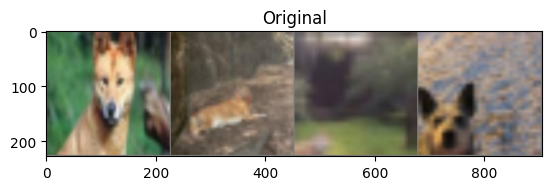

In [4]:
train_dir = "/content/data/train"
val_dir = "/content/data/val"
test_dir = "/content/data/test"

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    #CenterCrop(50),
])

train_data = ImageDataset(
    folder_path=train_dir,
    transform=transform,
)

val_data = ImageDataset(
    folder_path=val_dir,
    transform=transform,
)

test_data = ImageDataset(
    folder_path=test_dir,
    transform=transform,
)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

dataiter = iter(train_loader)
noisy_images, original_images = next(dataiter)

def imshow(img, title):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

#imshow(utils.make_grid(noisy_images[:4]), "Noisy")
imshow(utils.make_grid(original_images[:4]), "Original")

# Модель

In [5]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        latent_vector = self.encode(x)
        reconstructed = self.decode(latent_vector)
        return reconstructed

    def encode(self, image):
        return self.encoder(image)

    def decode(self, latent_vector):
        return self.decoder(latent_vector)

In [ ]:
#####################################################
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        return self.encoder(x)

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(x)

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(size=(50, 50), mode='bilinear', align_corners=False)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
################################################################
def train(model, train_loader, val_loader, criterion, optimizer, epochs):
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for noisy_images, original_images in train_loader:
            noisy_images = noisy_images.to(device)
            original_images = original_images.to(device)

            outputs = model(noisy_images)
            loss = criterion(outputs, original_images)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for noisy_images, original_images in val_loader:
                noisy_images = noisy_images.to(device)
                original_images = original_images.to(device)

                outputs = model(noisy_images)
                loss = criterion(outputs, original_images)
                val_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], training Loss: {train_loss/len(train_loader):.2f}, validation Loss: {val_loss/len(val_loader):.2f}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoEncoder().to(device)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train(model, train_loader, val_loader, criterion, optimizer, epoch)

Epoch [1/50], training Loss: 0.35, validation Loss: 0.30
Epoch [2/50], training Loss: 0.31, validation Loss: 0.29
Epoch [3/50], training Loss: 0.31, validation Loss: 0.29
Epoch [4/50], training Loss: 0.30, validation Loss: 0.28
Epoch [5/50], training Loss: 0.30, validation Loss: 0.28
Epoch [6/50], training Loss: 0.30, validation Loss: 0.28
Epoch [7/50], training Loss: 0.30, validation Loss: 0.28
Epoch [8/50], training Loss: 0.30, validation Loss: 0.28
Epoch [9/50], training Loss: 0.30, validation Loss: 0.28
Epoch [10/50], training Loss: 0.30, validation Loss: 0.28
Epoch [11/50], training Loss: 0.30, validation Loss: 0.28
Epoch [12/50], training Loss: 0.30, validation Loss: 0.28
Epoch [13/50], training Loss: 0.30, validation Loss: 0.28
Epoch [14/50], training Loss: 0.30, validation Loss: 0.28
Epoch [15/50], training Loss: 0.29, validation Loss: 0.28
Epoch [16/50], training Loss: 0.29, validation Loss: 0.28
Epoch [17/50], training Loss: 0.29, validation Loss: 0.27
Epoch [18/50], training

In [6]:
def cosine_distance(embedding1, embedding2):
    return 1 - F.cosine_similarity(embedding1, embedding2, dim=1).mean()

In [9]:
import torch.nn.functional as F

def train(model, train_loader, val_loader, criterion, optimizer, resnet, semantic_weight, epochs):
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        semantic_loss_sum = 0

        for noisy_images, original_images in train_loader:
            noisy_images = noisy_images.to(device)
            original_images = original_images.to(device)

            outputs = model(noisy_images)

            reconstruction_loss = criterion(outputs, original_images)

            with torch.no_grad():
                resized_original = F.interpolate(original_images, size=(224, 224), mode='bilinear', align_corners=False)
                original_embeddings = resnet(resized_original)

            resized_outputs = F.interpolate(outputs, size=(224, 224), mode='bilinear', align_corners=False)
            reconstructed_embeddings = resnet(resized_outputs)
            semantic_loss = 1 - F.cosine_similarity(original_embeddings, reconstructed_embeddings).mean()

            loss = reconstruction_loss + semantic_weight * semantic_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += reconstruction_loss.item()
            semantic_loss_sum += semantic_loss.item()

        model.eval()
        val_loss = 0
        val_semantic_loss_sum = 0
        with torch.no_grad():
            for noisy_images, original_images in val_loader:
                noisy_images = noisy_images.to(device)
                original_images = original_images.to(device)

                outputs = model(noisy_images)
                reconstruction_loss = criterion(outputs, original_images)

                resized_original = F.interpolate(original_images, size=(224, 224), mode='bilinear', align_corners=False)
                original_embeddings = resnet(resized_original)

                resized_outputs = F.interpolate(outputs, size=(224, 224), mode='bilinear', align_corners=False)
                reconstructed_embeddings = resnet(resized_outputs)
                semantic_loss = cosine_distance(original_embeddings, reconstructed_embeddings)

                loss = reconstruction_loss + semantic_weight * semantic_loss

                val_loss += reconstruction_loss.item()
                val_semantic_loss_sum += semantic_loss.item()

        print(
            f"Epoch [{epoch+1}/{epochs}], "
            f"Train Loss: {train_loss/len(train_loader):.4f}, "
            f"Train Semantic Loss: {semantic_loss_sum/len(train_loader):.4f}, "
            f"Val Loss: {val_loss/len(val_loader):.4f}, "
            f"Val Semantic Loss: {val_semantic_loss_sum/len(val_loader):.4f}"
        )

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE().to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

resnet = models.resnet18(pretrained=True)
resnet.fc = nn.Identity()
resnet = resnet.to(device)
resnet.eval()

semantic_weight = 0.1

train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    resnet=resnet,
    semantic_weight=semantic_weight,
    epochs=50
)

KeyboardInterrupt: 

In [8]:
#####################################################
def train(model, train_loader, val_loader, criterion, optimizer, resnet, semantic_weight, epochs):
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        semantic_loss_sum = 0

        for noisy_images, original_images in train_loader:
            noisy_images = noisy_images.to(device)
            original_images = original_images.to(device)

            outputs = model(noisy_images)

            reconstruction_loss = criterion(outputs, original_images)

            with torch.no_grad():
                original_embeddings = resnet(original_images)
            reconstructed_embeddings = resnet(outputs)
            semantic_loss = cosine_distance(original_embeddings, reconstructed_embeddings)

            loss = reconstruction_loss + semantic_weight * semantic_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += reconstruction_loss.item()
            semantic_loss_sum += semantic_loss.item()

        model.eval()
        val_loss = 0
        val_semantic_loss_sum = 0
        with torch.no_grad():
            for noisy_images, original_images in val_loader:
                noisy_images = noisy_images.to(device)
                original_images = original_images.to(device)

                outputs = model(noisy_images)
                reconstruction_loss = criterion(outputs, original_images)

                original_embeddings = resnet(original_images)
                reconstructed_embeddings = resnet(outputs)
                semantic_loss = cosine_distance(original_embeddings, reconstructed_embeddings)

                loss = reconstruction_loss + semantic_weight * semantic_loss

                val_loss += reconstruction_loss.item()
                val_semantic_loss_sum += semantic_loss.item()

        print(f"epoch [{epoch+1}/{epochs}], "
            f"train Loss: {train_loss/len(train_loader):.2f}, "
            f"train semantic Loss: {semantic_loss_sum/len(train_loader):.2f}, "
            f"val Loss: {val_loss/len(val_loader):.2f}, "
            f"val semantic Loss: {val_semantic_loss_sum/len(val_loader):.2f}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE().to(device)

criterion = nn.L1Loss()

optimizer = optim.Adam(model.parameters(), lr=1e-3)

resnet = models.resnet18(pretrained=True)
resnet.fc = nn.Identity()
resnet = resnet.to(device)
resnet.eval()

semantic_weight = 0.1

train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    resnet=resnet,
    semantic_weight=semantic_weight,
    epochs=50
)

KeyboardInterrupt: 

# Проверка качетва модели
Сгенерированы несколько примеров из случайных латентных векторов для сравнения с реальными данными.


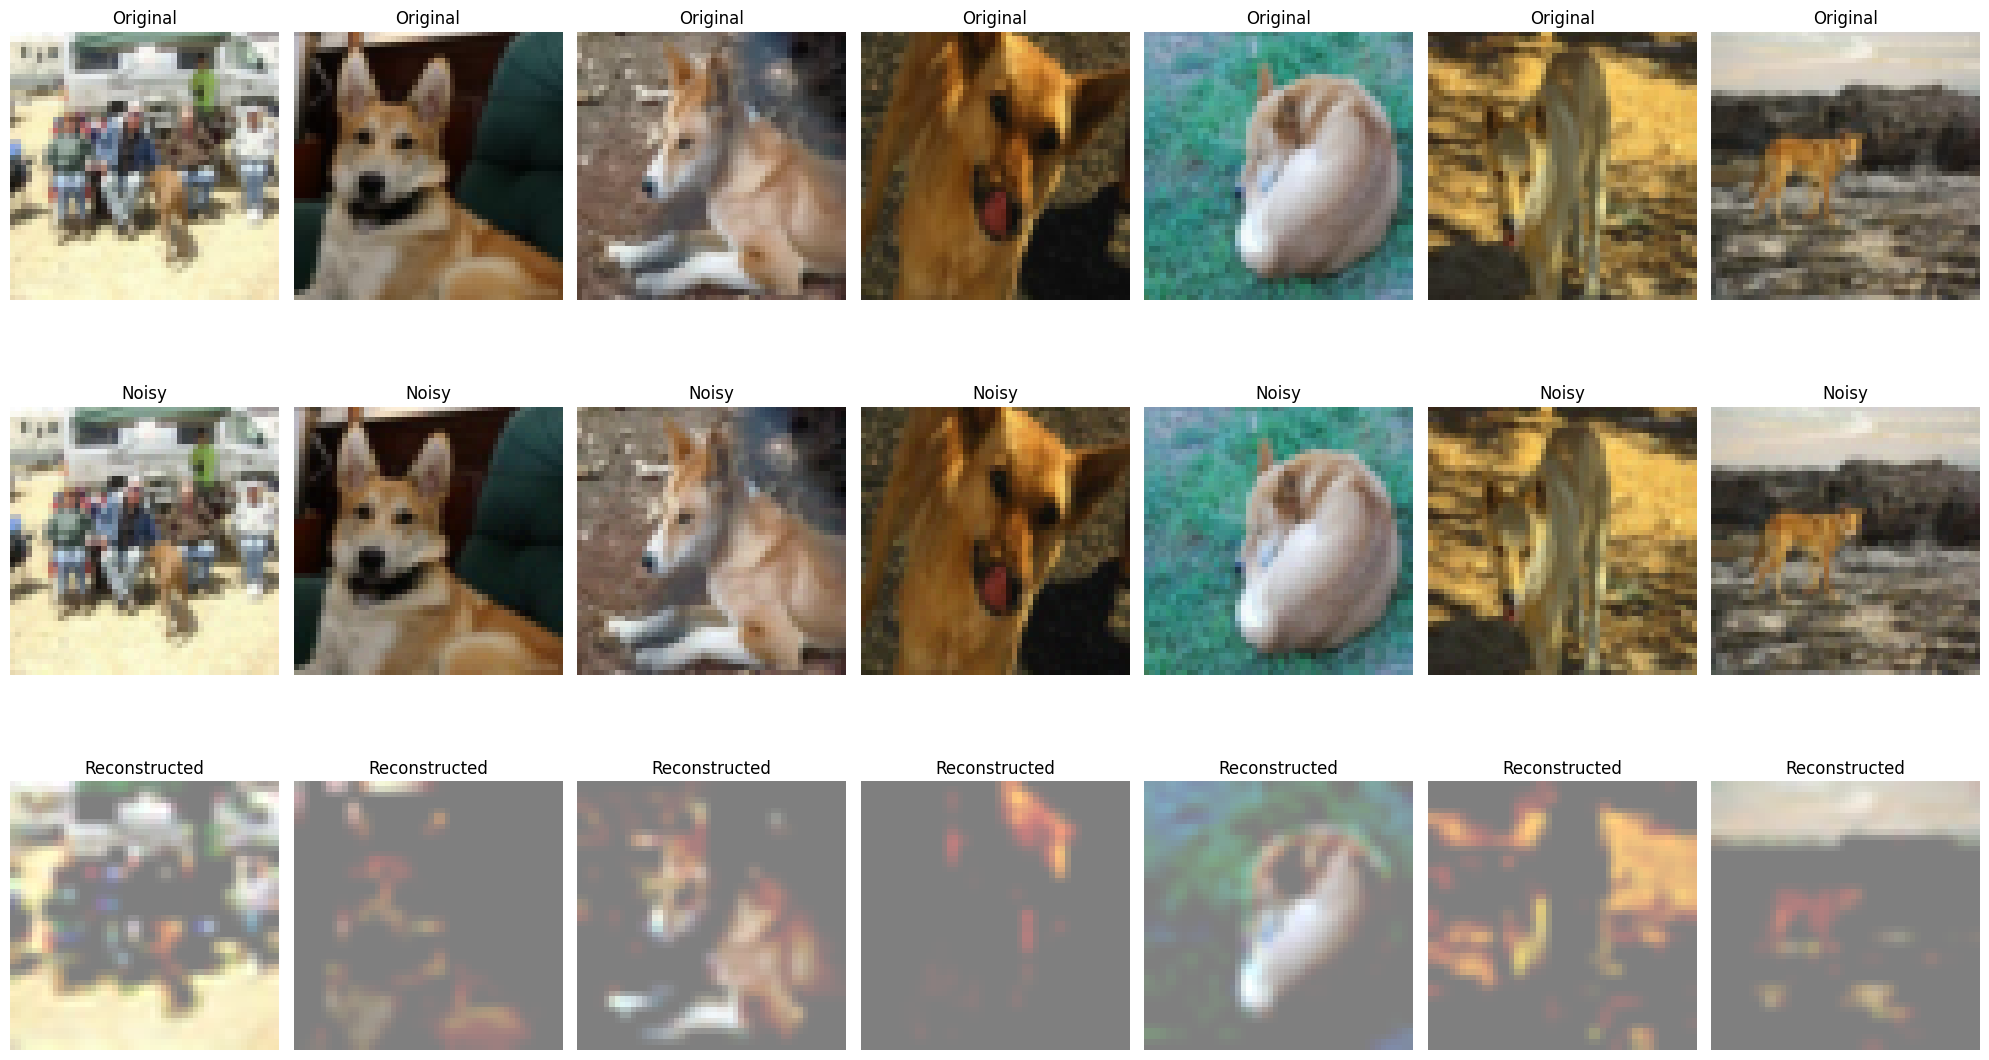

In [ ]:
def reconstruction(model, test_loader):
    model.eval()
    with torch.no_grad():
        noisy_images, original_images = next(iter(test_loader))

        noisy_images = noisy_images.to(device)
        outputs = model(noisy_images)

        num_images = 7
        noisy_images = noisy_images[:num_images]
        original_images = original_images[:num_images]
        outputs = outputs[:num_images]

        noisy_images = noisy_images.cpu().numpy().transpose(0, 2, 3, 1)
        original_images = original_images.cpu().numpy().transpose(0, 2, 3, 1)
        outputs = outputs.cpu().numpy().transpose(0, 2, 3, 1)

        noisy_images = (noisy_images * 0.5) + 0.5
        original_images = (original_images * 0.5) + 0.5
        outputs = (outputs * 0.5) + 0.5

        fig, axes = plt.subplots(3, num_images, figsize=(20, 12))
        for i in range(num_images):
            axes[0, i].imshow(original_images[i].clip(0, 1))
            axes[0, i].set_title("Original", fontsize=12)
            axes[0, i].axis('off')

            axes[1, i].imshow(noisy_images[i].clip(0, 1))
            axes[1, i].set_title("Noisy", fontsize=12)
            axes[1, i].axis('off')

            axes[2, i].imshow(outputs[i].clip(0, 1))
            axes[2, i].set_title("Reconstructed", fontsize=12)
            axes[2, i].axis('off')

        plt.tight_layout()
        plt.show()

reconstruction(model, test_loader)

# Gif с latent space interpolation

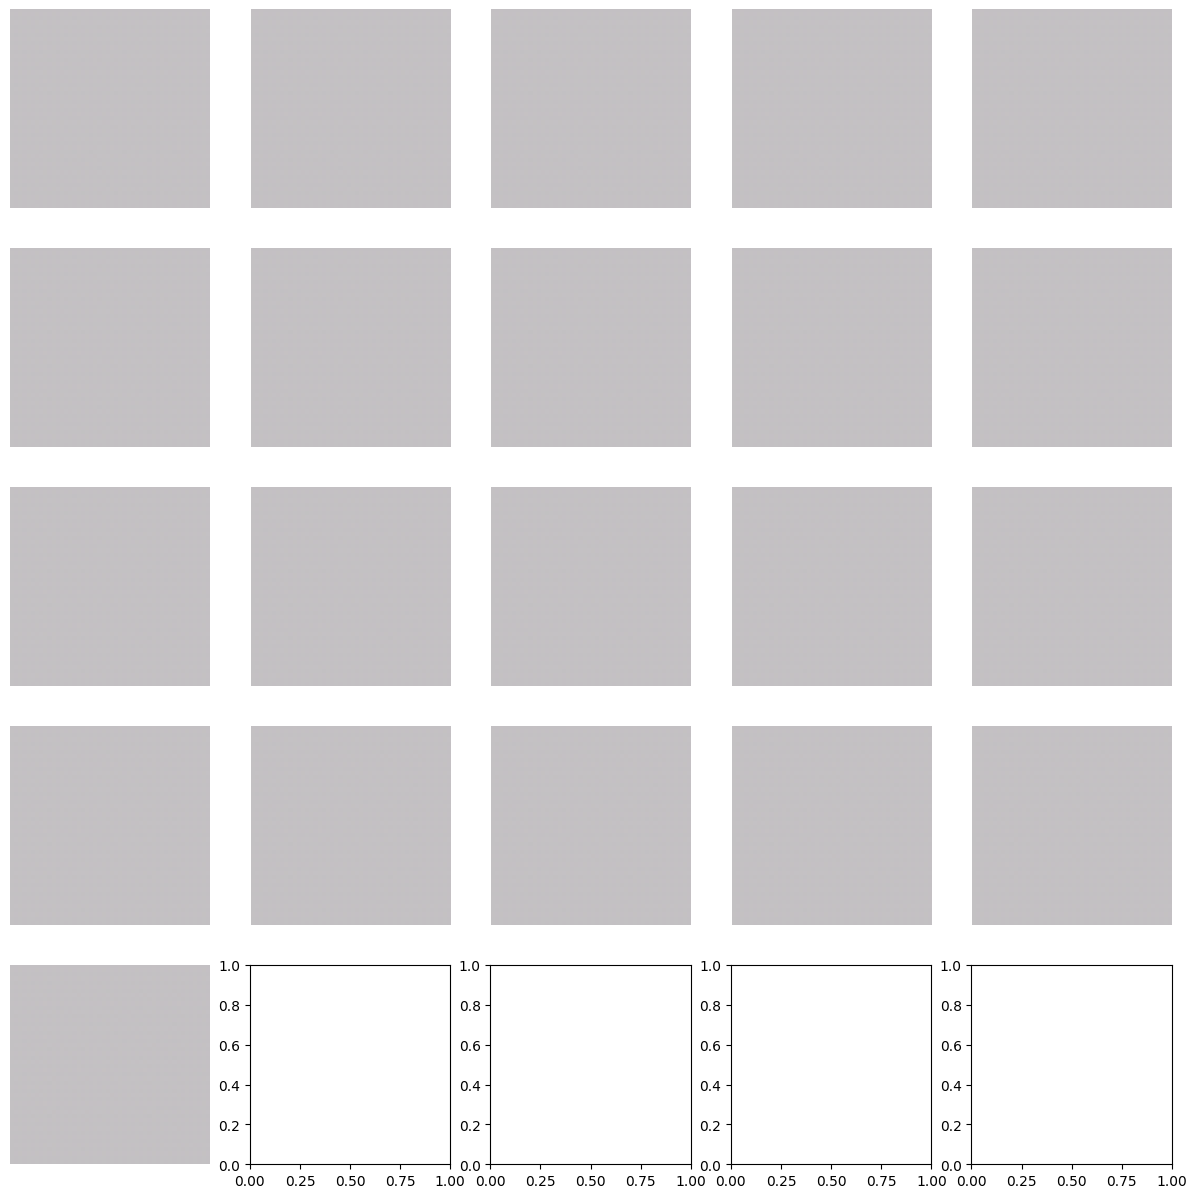

GIF сохранен по пути: latent_interpolation.gif


In [ ]:
import torch
import matplotlib.pyplot as plt
import imageio

def interpolate(v1, v2, alpha):
    return v1 * (1 - alpha) + v2 * alpha

def generate(encoder, decoder, dataset, steps=10, device="cpu"):
    img_a, _ = dataset[0]
    img_b, _ = dataset[1]

    img_a = img_a.unsqueeze(0).to(device)
    img_b = img_b.unsqueeze(0).to(device)

    latent_a = encoder(img_a)
    latent_b = encoder(img_b)

    images = []
    for step in range(steps + 1):
        alpha = step / steps
        interpolated_vector = interpolate(latent_a, latent_b, alpha)

        generated_image = decoder(interpolated_vector).squeeze(0).cpu()
        generated_image = (generated_image * 0.5) + 0.5
        images.append(generated_image.detach().numpy().transpose(1, 2, 0))

    return images

def show_images(images, cols=5):
    rows = len(images) // cols + (1 if len(images) % cols != 0 else 0)
    fig, ax = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    for i, img in enumerate(images):
        ax[i // cols, i % cols].imshow(img.clip(0, 1))
        ax[i // cols, i % cols].axis('off')
    plt.show()

def save_to_gif(images, output_path="latent_interpol.gif"):
    images = [(img * 255).astype("uint8") for img in images]
    imageio.mimsave(output_path, images, duration=0.1)
    print(f"GIF: {output_path}")

device = "cpu"
encoder = Encoder().to(device)
decoder = Decoder().to(device)

images = generate(encoder, decoder, test_data, steps=20, device=device)
show_images(images, cols=5)
save_to_gif(images)

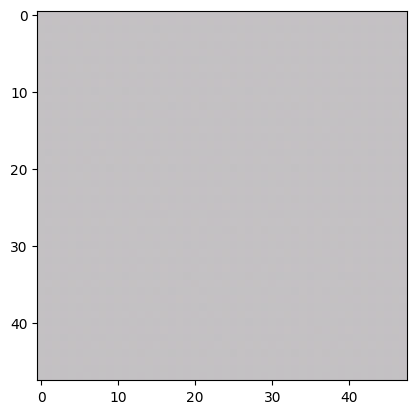

In [ ]:
test_vector = encoder(test_data[0][0].unsqueeze(0).to(device))
generated_image = decoder(test_vector).squeeze(0).cpu()
plt.imshow((generated_image.detach().numpy().transpose(1, 2, 0) * 0.5) + 0.5)
plt.show()